# Introduction to Natural Language Processing with TensorFlow

## What is NLP?
NLP stands for Natural Language Processing, is a field in computer science that deals with the interaction between computers and human languages, particularly on programming computers to process and analyze large amount of natural language data.

## 2 main categories under NLP
- Natural Language Understanding - the computer’s ability to understand what we say
- Natural Language Generation - the generation of natural language by a computer

In recent years, Natural Language Processing (NLP) has experienced fast growth as a field, both because of improvements to the language model architectures and because they've been trained on increasingly large text corpora. As a result, their ability to "understand" text has vastly improved, and large pre-trained models such as BERT have become widely used.

## Applications of NLP
Some of the popular applications you probably have seen are ChatGPT and Bard Google. They are large language models (LLMs) that are trained on massive datasets of text and code. This allows them to generate text, translate languages, write different kinds of creative content, and answer your questions in an informative way.

## Learning Objectives
Today we will focus on the fundamental aspects of representing NLP as tensors in TensorFlow, and on classical NLP architectures, such as using bag-of-words, embeddings and recurrent neural networks.

## What are tensors?
- A tensor is a multi-dimensional array that represents a sequence of text. They are used to store and process text data in neural networks.
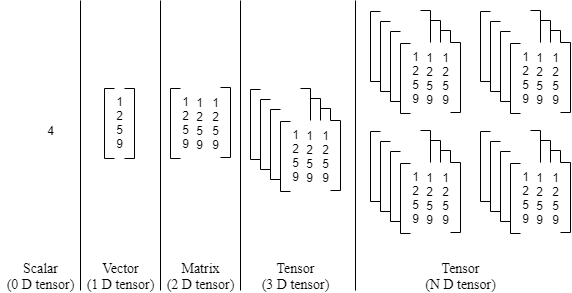

## Why do we need tensor to represent text data?
- Computers cannot understand characters, so what we do is map letters to ASCII and binary representation so that our computers understand how all characters come together to form the words of a sentence. This is where tensors come in. They provide a way to represent text data as numbers, which can then be processed by neural networks.

## What is Neural Network?
- Neural networks are a type of machine learning model that are very good at processing text data.

## 2 approaches to represent text
> Character-level representation, where we represent text by treating each character as a number. Given that we have C different characters in our text corpus, the word "Hello" could be represented by a tensor with shape C×5. Each letter would correspond to a tensor in one-hot encoding. This is useful for tasks that require understanding the morphology of words, such as part-of-speech tagging and spelling correction. However, it can be computationally expensive to process text at the character level, and it can be difficult to capture the semantic meaning of words.

> Word-level representation, in which we create a vocabulary of all words in our text, and then represent words using one-hot encoding. This approach is better than character-level representation because each letter by itself does not have much meaning. Using word-level representation, we can capture the semantic meaning of words more effectively, however, given a large dictionary size, we need to deal with high-dimensional sparse tensors and out-of-vocabulary words.

## Terms to understand
- One-hot encoding: a way of representing a categorical variable as a vector. Text is considered a categorical variable, for example: gender, race, positive sentiment, and etc. (Tensors are not one-hot-encoding)
- Morphology of word: refers to the internal structure of a word, for example: the word "walk" has the stem "walk" and the affix "-ed". (Time to check back your english grammar)
- Semantic meaning of words: refers to the meaning of words in terms of their concepts and relationships, for example: "dog", "yellow" and "yellow dog".
- Out-of-vocabulary words: words that are not present in the vocabulary of a machine learning model. This can happen when the model is trained on a dataset that does not contain all of the words that it will encounter in the real world. When a model encounters an OOV word, it has to guess what the word means based on the context in which it is used. This can be a challenge, and it can lead to errors in the model's predictions.
- Stop words: common words that are not informative in the context of text analysis, for example: "the", "is", "and", "of", "to", "in", and "that". These words are so common that they appear in almost every piece of text, and they do not provide any additional information about the meaning of the text.

# Hands-on

In [1]:
!pip install --user --quiet tensorflow-datasets wget protobuf==3.20

## Text classification task

In this module, we will start with a simple text classification task based on the **[AG_NEWS](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)** dataset: we'll classify news headlines into one of 4 categories: World, Sports, Business and Sci/Tech. To load the dataset, we will use the **[TensorFlow Datasets](https://www.tensorflow.org/datasets)** API.

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

dataset = tfds.load('ag_news_subset')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\WT\tensorflow_datasets\ag_news_subset\1.0.0.incompleteRTFCSG\ag_news_subset-train.tfrecord*…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\WT\tensorflow_datasets\ag_news_subset\1.0.0.incompleteRTFCSG\ag_news_subset-test.tfrecord*.…

Dataset ag_news_subset downloaded and prepared to C:\Users\WT\tensorflow_datasets\ag_news_subset\1.0.0. Subsequent calls will reuse this data.


We can now access the training and test portions of the dataset by using `dataset['train']` and `dataset['test']` respectively:

In [4]:
ds_train = dataset['train']
ds_test = dataset['test']

print(f"Length of train dataset = {len(ds_train)}")
print(f"Length of test dataset = {len(ds_test)}")

Length of train dataset = 120000
Length of test dataset = 7600


Let's print out the first 10 new headlines from our dataset: 

In [5]:
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

for i,x in zip(range(5),ds_train):
    print(f"{x['label']} ({classes[x['label']]}) -> {x['title']} {x['description']}")

3 (Sci/Tech) -> b'AMD Debuts Dual-Core Opteron Processor' b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
1 (Sports) -> b"Wood's Suspension Upheld (Reuters)" b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
2 (Business) -> b'Bush reform may have blue states seeing red' b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
3 (Sci/Tech) -> b"'Halt science decline in schools'" b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
1 (Sports) -> b'Gerrard leaves practice' b'London, England (Sports Network

### Text vectorization

Now we need to convert text into **numbers** that can be represented as tensors. If we want word-level representation, we need to do two things:

* Use a **tokenizer** to split text into **tokens**.
* Build a **vocabulary** of those tokens.

#### Limiting vocabulary size

In the AG News dataset example, the vocabulary size is rather big, more than 100k words. Generally speaking, we don't need words that are rarely present in the text &mdash; only a few sentences will have them, and the model will not learn from them. Thus, it makes sense to limit the vocabulary size to a smaller number by passing an argument to the vectorizer constructor:

Both of those steps can be handled using the **TextVectorization** layer. Let's instantiate the vectorizer object, and then call the `adapt` method to go through all text and build a vocabulary:



In [6]:
vocab_size = 50000
vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)
vectorizer.adapt(ds_train.take(500).map(lambda x: x['title']+' '+x['description']))

> **NOTE** The max_tokens parameter in the TextVectorization layer specifies the maximum number of tokens that will be included in the vocabulary. This is useful for two reasons: 
1. It can help to improve the performance of the model. If the vocabulary is too large, it can take longer to train the model and to predict the labels for new text. 
2. It can help to prevent overfitting. If the vocabulary is too large, the model may learn to associate specific tokens with specific labels, even if those tokens are not very informative.

> **SUMMARY** The vector will take 500 samples from the training data and find the most frequent maximum 50000 words in these 500 samples to make a vocabulary that makes the 50000-sized tensors/vectors.

> **NOTE** that we are using only subset of the whole dataset to build a vocabulary. We do it to speed up the execution time and not keep you waiting. However, we are taking the risk that some of the words from the whole dateset would not be included into the vocabulary, and will be ignored during training. If you want to ensure that all words from the dataset are included in the vocabulary, you can call the adapt() method with the entire dataset. This will increase the execution time of the code, but it will ensure that all words from the dataset are included in the vocabulary.

Now we can access the actual vocabulary:

In [7]:
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
print(vocab[:10])
print(f"Length of vocabulary: {vocab_size}")

['', '[UNK]', 'the', 'to', 'a', 'in', 'of', 'and', 'on', 'for']
Length of vocabulary: 5335


> **NOTE** The length of the vocabulary is only 5335 because the adapt() method on the TextVectorization layer will only build the vocabulary from the most frequent tokens in the dataset, up to the maximum vocabulary size. In your example, the maximum vocabulary size is 50000 tokens, but the 500 samples that you passed to the adapt() method only contain 5335 unique tokens.

> **Question** We said it will make 50000-sized vectors, since there is only 5335 unique tokens. What happened to the empty spaces in the vector?

>**Answer**: 
If the maximum vocabulary size is set to 50000, each vector will be of size 50000, even if the vocabulary only contains 5335 tokens. The remaining empty spaces in the vector will be filled with zeros.
This is because the TextVectorization layer uses a one-hot encoding scheme to represent tokens in the vocabulary. In one-hot encoding, each token is represented by a vector of size 50000, where the only non-zero entry is at the index of the token in the vocabulary.
So, if the vocabulary only contains 5335 tokens, the remaining 44665 entries in each vector will be filled with zeros.
**This can be wasteful of memory.**

Using the tokenizer, we can easily encode any text into a set of numbers:

In [8]:
vectorizer('I love to play with my words')

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 112, 3695,    3,  304,   11, 1041,    1], dtype=int64)>

The first element in the vector is 112. This means that the word "I" is the 112th most frequent word in the vocabulary. The second element in the vector is 3695. This means that the word "love" is the 3695th most frequent word in the vocabulary.

The vectorizer will only create a vector for each word that appears in the text. This is why the vector has a shape of (7,) even though the vocabulary has a size of 50,000.

### Bag-of-words text representation

Because words represent meaning, sometimes we can figure out the meaning of a piece of text by just looking at the individual words, regardless of their order in the sentence. For example, when classifying news, words like *weather* and *snow* are likely to indicate *weather forecast*, while words like *stocks* and *dollar* would count towards *financial news*.

**Bag-of-words** (BoW) vector representation is the most simple to understand traditional vector representation. Each word is linked to a vector index, and a vector element contains the number of occurrences of each word in a given document.

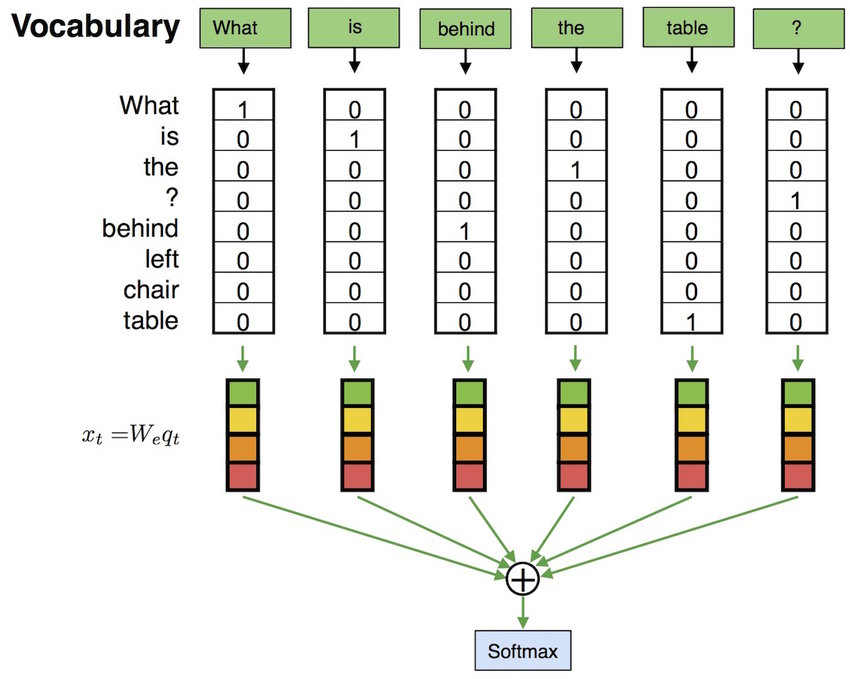

> **Note**: You can also think of BoW as a sum of all one-hot-encoded vectors for individual words in the text.

Below is an example of how to generate a bag-of-words representation using the Scikit Learn python library:

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
sc_vectorizer = CountVectorizer()
corpus = [
  'I like hot Dogs.',
  'The dog ran fast.',
  'Its hot outside.',
]
sc_vectorizer.fit_transform(corpus)
features = sc_vectorizer.get_feature_names_out()
print("Features: ", features)
print("Vector size: ", len(features))
print(sc_vectorizer.transform(['My dog likes hot dogs on a hot day. LA']).toarray())

Features:  ['dog' 'dogs' 'fast' 'hot' 'its' 'like' 'outside' 'ran' 'the']
Vector size:  9
[[1 1 0 2 0 0 0 0 0]]


> From here you can see, the CountVectorizer has already removed the stop words (uninformative common words), lower case the words, rearrange the vocab according to alphabetical order.

> But, they cannot differentiate separate words that have affixes: "dog" and "dogs". That's what we called "it cannot understand the semantic meaning of the words". What they do is only considering the frequency of each word in a document and another problem is it cannot detect out-of-vocabulary words.

We can also use the Keras vectorizer that we defined above, converting each word number into a one-hot encoding and adding all those vectors up:

In [31]:
# The to_bow() function first uses the vectorizer() function to convert the 
# text to a vector. The vectorizer() function uses a one-hot encoding scheme 
# to represent the tokens in the text. In one-hot encoding, each token is 
# represented by a vector of size vocab_size, where the only non-zero entry 
# is at the index of the token in the vocabulary.

# The to_bow() function then uses the tf.reduce_sum() function to sum the 
# vector across the axis=0. This means that the function will sum the values 
# in the vector for each token, and return a vector that contains the number 
# of times each token appears in the text.

def to_bow(text):
  return tf.reduce_sum(tf.one_hot(vectorizer(text),vocab_size),axis=0)

to_bow_vector = to_bow('My dog likes hot dogs on a hot day.').numpy()
print(to_bow_vector)
print(len(to_bow_vector))

[0. 5. 0. ... 0. 0. 0.]
5335


> **Note**: You may be surprised that the result differs from the previous example. The reason is that in the Keras example the length of the vector corresponds to the vocabulary size, which was built from the whole AG News dataset, while in the Scikit Learn example we built the vocabulary from the sample text on the fly. 


### Training the BoW classifier

Now that we have learned how to build the bag-of-words representation of our text, let's train a classifier that uses it. First, we need to convert our dataset to a bag-of-words representation. This can be achieved by using `map` function in the following way:

In [32]:
batch_size = 128

ds_train_bow = ds_train.map(lambda x: (to_bow(x['title']+x['description']),x['label'])).batch(batch_size)
ds_test_bow = ds_test.map(lambda x: (to_bow(x['title']+x['description']),x['label'])).batch(batch_size)

It will create multiple 128 batches of the bag-of-words representations of the text in the training and test datasets. The use of batching can improve the performance of machine learning algorithms. This is because batching allows the algorithm to process multiple samples at the same time, which can speed up the training process.

Now let's define a simple classifier neural network that contains one linear layer. The input size is `vocab_size`, and the output size corresponds to the number of classes (4). Because we're solving a classification task, the final activation function is **softmax**:

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(4,activation='softmax',input_shape=(vocab_size,))
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(ds_train_bow,validation_data=ds_test_bow)

938/938 [==============================] - 35s 37ms/step - loss: 0.6158 - acc: 0.8410 - val_loss: 0.4415 - val_acc: 0.8691


The model has 4 layers:

1. An input layer with a shape of (vocab_size,)
2. A dense layer with 4 neurons
3. A softmax activation function
4. A loss function of sparse_categorical_crossentropy
5. An optimizer of adam
6. A metric of accuracy

The input layer is responsible for receiving the input data. The input data is a vector of integers, where each integer represents a word in the vocabulary. The input layer has a shape of (vocab_size,) because there are a total of vocab_size words in the vocabulary.

The dense layer is responsible for learning the relationships between the words in the input data. The dense layer has 4 neurons, which means that the model can learn up to 4 different relationships between the words.

The softmax activation function is responsible for converting the output of the dense layer into a probability distribution. The probability distribution represents the probability that the input data belongs to each of the 4 classes.

The loss function is responsible for measuring the difference between the predicted output of the model and the actual output. The loss function used in the code is sparse_categorical_crossentropy. This loss function is specifically designed for multi-class classification problems where the labels are integers.

The optimizer is responsible for updating the weights of the model in order to minimize the loss function. The optimizer used in the code is adam. Adam is a popular optimizer that is known for its fast convergence.

The metric is responsible for evaluating the performance of the model. The metric used in the code is accuracy. Accuracy is the percentage of the time that the model correctly predicts the output.

The number of layers in the model is a hyperparameter that can be tuned to improve the performance of the model. In general, more layers will allow the model to learn more complex relationships between the words in the input data. However, more layers will also make the model more computationally expensive to train.

The choice of loss function is also a hyperparameter that can be tuned to improve the performance of the model. The loss function should be chosen to be appropriate for the type of problem that the model is trying to solve. In the case of multi-class classification, sparse_categorical_crossentropy is a good choice of loss function.

The choice of optimizer is also a hyperparameter that can be tuned to improve the performance of the model. The optimizer should be chosen to be appropriate for the type of problem that the model is trying to solve and the size of the dataset. In general, adam is a good choice of optimizer for most problems.

The choice of metric is also a hyperparameter that can be tuned to improve the performance of the model. The metric should be chosen to be appropriate for the type of problem that the model is trying to solve. In the case of multi-class classification, accuracy is a good choice of metric.

Since we have 4 classes, an accuracy of above 80% is a good result.

### Training a classifier as one network

Because the vectorizer is also a Keras layer, we can define a network that includes it, and train it end-to-end. This way we don't need to vectorize the dataset using `map`, we can just pass the original dataset to the input of the network.

> **Note**: We would still have to apply maps to our dataset to convert fields from dictionaries (such as `title`, `description` and `label`) to tuples. However, when loading data from disk, we can build a dataset with the required structure in the first place.

In [39]:
def extract_text(x):
    return x['title']+' '+x['description']

def tupelize(x):
    return (extract_text(x),x['label'])

inp = keras.Input(shape=(1,),dtype=tf.string)
x = vectorizer(inp)
x = tf.reduce_sum(tf.one_hot(x,vocab_size),axis=1)
out = keras.layers.Dense(4,activation='softmax')(x)
model = keras.models.Model(inp,out)
model.summary()

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(ds_train.map(tupelize).batch(batch_size),validation_data=ds_test.map(tupelize).batch(batch_size))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 5335)        0         
                                                                 
 tf.math.reduce_sum (TFOpLam  (None, 5335)             0         
 bda)                                                            
                                                                 
 dense_1 (Dense)             (None, 4)                 21344     
                                                                 
Total params: 21,344
Trainable params: 21,344
Non-trainable p

The first layer in the model is an InputLayer. This layer is responsible for receiving the input data. The input data is a string, and the InputLayer will convert it into a tensor of shape (1,).

The second layer in the model is a TextVectorization layer. This layer is responsible for converting the input text into a numerical representation. The TextVectorization layer will use the vocabulary that was created earlier to convert the input text into a tensor of shape (None, None).

The third layer in the model is a TensorFlow OpLambda layer. This layer is responsible for converting the output of the TextVectorization layer into a one-hot encoded tensor. The one-hot encoded tensor will have a shape of (None, None, 5335), where 5335 is the size of the vocabulary.

The fourth layer in the model is another TensorFlow OpLambda layer. This layer is responsible for reducing the output of the one-hot encoded tensor to a vector of shape (None, 5335). This is done by taking the sum of each column in the one-hot encoded tensor.

The fifth and final layer in the model is a Dense layer. This layer is responsible for learning the relationships between the words in the input data. The Dense layer has 4 neurons, which means that the model can learn up to 4 different relationships between the words.

The summary of the model shows that the model has a total of 21,344 parameters. This number of parameters is relatively small, which means that the model is not very complex. However, the model may still be able to learn to classify text accurately, depending on the size and quality of the training dataset.


The total params and trainable params are two metrics that are used to measure the complexity of a Keras model.

Total params refers to the total number of parameters in the model, including both trainable and non-trainable parameters.
Trainable params refers to the number of parameters in the model that can be updated during training.
The total number of parameters in a model is a good measure of its complexity. However, it is important to note that not all parameters are created equal. Some parameters are more important than others, and some parameters are more difficult to train than others.

The trainable parameters are the most important parameters in a model. These are the parameters that are updated during training, and they are the parameters that are responsible for learning the relationships between the data.

The non-trainable parameters are the parameters that are not updated during training. These parameters are usually used for things like normalization and regularization.

In general, a model with more trainable parameters will be able to learn more complex relationships between the data. However, a model with too many trainable parameters can be difficult to train and may not generalize well to new data.

The best way to determine the number of trainable parameters that a model needs is to experiment. You can start with a small number of trainable parameters and increase the number until the model starts to overfit the training data.

### Bigrams, trigrams and n-grams

One limitation of the bag-of-words approach is that some words are part of multi-word expressions, for example, the word 'hot dog' has a completely different meaning from the words 'hot' and 'dog' in other contexts. If we represent the words 'hot' and 'dog' always using the same vectors, it can confuse our model.

To address this, **n-gram representations** are often used in methods of document classification, where the frequency of each word, bi-word or tri-word is a useful feature for training classifiers. In bigram representations, for example, we will add all word pairs to the vocabulary, in addition to original words.

Below is an example of how to generate a bigram bag of word representation using Scikit Learn:

In [40]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
corpus = [
  'I like hot dogs.',
  'The dog ran fast.',
  'Its hot outside.',
]
bigram_vectorizer.fit_transform(corpus)
print("Vocabulary:\n",bigram_vectorizer.vocabulary_)
bigram_vectorizer.transform(['My dog likes hot dogs on a hot day.']).toarray()


Vocabulary:
 {'i': 7, 'like': 11, 'hot': 4, 'dogs': 2, 'i like': 8, 'like hot': 12, 'hot dogs': 5, 'the': 16, 'dog': 0, 'ran': 14, 'fast': 3, 'the dog': 17, 'dog ran': 1, 'ran fast': 15, 'its': 9, 'outside': 13, 'its hot': 10, 'hot outside': 6}


array([[1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

The main drawback of the n-gram approach is that the vocabulary size starts to grow extremely fast. In practice, we need to combine the n-gram representation with a dimensionality reduction technique, such as *embeddings*, which we will discuss in the next unit.

To use an n-gram representation in our **AG News** dataset, we need to pass the `ngrams` parameter to our `TextVectorization` constructor. The length of a bigram vocaculary is **significantly larger**, in our case it is more than 1.3 million tokens! Thus it makes sense to limit bigram tokens as well by some reasonable number.

We could use the same code as above to train the classifier, however, it would be very memory-inefficient. In the next unit, we will train the bigram classifier using embeddings. In the meantime, you can experiment with bigram classifier training in this notebook and see if you can get higher accuracy.

### Automatically calculating BoW Vectors

In the example above we calculated BoW vectors by hand by summing the one-hot encodings of individual words. However, the latest version of TensorFlow allows us to calculate BoW vectors automatically by passing the `output_mode='count` parameter to the vectorizer constructor. This makes defining and training our model significanly easier:

In [41]:
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,output_mode='count'),
    keras.layers.Dense(4,input_shape=(vocab_size,), activation='softmax')
])
print("Training vectorizer")
model.layers[0].adapt(ds_train.take(500).map(extract_text))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(ds_train.map(tupelize).batch(batch_size),validation_data=ds_test.map(tupelize).batch(batch_size))

Training vectorizer
938/938 [==============================] - 6s 6ms/step - loss: 0.5902 - acc: 0.8506 - val_loss: 0.4166 - val_acc: 0.8775


### Term frequency - inverse document frequency (TF-IDF)

In BoW representation, word occurrences are weighted using the same technique regardless of the word itself. However, it's clear that frequent words such as *a* and *in* are much less important for classification than specialized terms. In most NLP tasks some words are more relevant than others.

**TF-IDF** stands for **term frequency - inverse document frequency**. It's a variation of bag-of-words, where instead of a binary 0/1 value indicating the appearance of a word in a document, a floating-point value is used, which is related to the frequency of the word occurrence in the corpus.

More formally, the weight $w_{ij}$ of a word $i$ in the document $j$ is defined as:
$$
w_{ij} = tf_{ij}\times\log({N\over df_i})
$$
where
* $tf_{ij}$ is the number of occurrences of $i$ in $j$, i.e. the BoW value we have seen before
* $N$ is the number of documents in the collection
* $df_i$ is the number of documents containing the word $i$ in the whole collection

The TF-IDF value $w_{ij}$ increases proportionally to the number of times a word appears in a document and is offset by the number of documents in the corpus that contains the word, which helps to adjust for the fact that some words appear more frequently than others. For example, if the word appears in *every* document in the collection, $df_i=N$, and $w_{ij}=0$, and those terms would be completely disregarded.

You can easily create TF-IDF vectorization of text using Scikit Learn:

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit_transform(corpus)
vectorizer.transform(['My dog likes hot dogs on a hot day.']).toarray()

array([[0.43381609, 0.        , 0.43381609, 0.        , 0.65985664,
        0.43381609, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In Keras, the `TextVectorization` layer can automatically compute TF-IDF frequencies by passing the `output_mode='tf-idf'` parameter. Let's repeat the code we used above to see if using TF-IDF increases accuracy: 

In [43]:
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,output_mode='tf-idf'),
    keras.layers.Dense(4,input_shape=(vocab_size,), activation='softmax')
])
print("Training vectorizer")
model.layers[0].adapt(ds_train.take(500).map(extract_text))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(ds_train.map(tupelize).batch(batch_size),validation_data=ds_test.map(tupelize).batch(batch_size))

Training vectorizer
938/938 [==============================] - 6s 6ms/step - loss: 0.4102 - acc: 0.8708 - val_loss: 0.3415 - val_acc: 0.8851


### Conclusion 

Even though TF-IDF representations provide frequency weights to different words, they are unable to represent meaning or order. As the famous linguist J. R. Firth said in 1935, "The complete meaning of a word is always contextual, and no study of meaning apart from context can be taken seriously." We will learn how to capture contextual information from text using language modeling in a later unit.